In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import markers

# $\star$ Question 2: 
Estimate the mean and covariance matrix of the dataset *gaussian.npz* via ML
estimation.

Plot the points and indicate the mean via a cross and the covariance via an
ellipse. 

Consult the matplotlib documentation to see how to draw an ellipse. 
(https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Ellipse.html)


You obtain the ellipse axes by an eigen-decomposition of the matrix (Numpy function linalg.eig). 

The scaling of the axes is given by the eigenvalues. Review the concept of an eigen-decomposition in the
internet or a math book if you lack this basic math knowledge.

# Question 2.1: Mean and Covariance estimation 
Estimate the mean and covariance matrix of the dataset, you can compare these to the built in numpy functions and see if you see a difference.

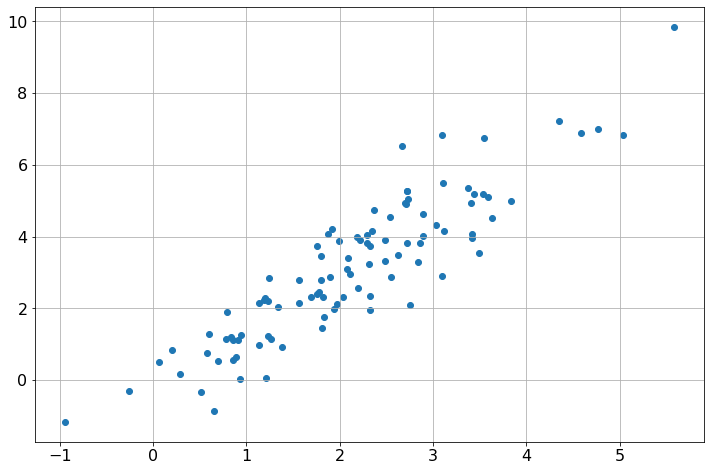

In [2]:
data = np.load('../data/gaussian.npz')
gaussian = data["arr_0"]

plt.rc('font', size=16) 
plt.figure(figsize=(12, 8))
plt.scatter(gaussian[:, 0], gaussian[:, 1])   # look at how the data is distributed
plt.grid()
plt.show()

Our data is of shape `(N_datapoints, D_features)` so to find the mean we sum over the datapoints over the first axis and divide over the number of datapoints.

In [3]:
N = len(gaussian)
mean = np.sum(gaussian, axis=0) / N
print(f"The estimated mean is: {mean}")

# compare result with numpy built in mean function
true_mean = np.mean(gaussian, axis=0)
print(f"The mean calculated using np.mean is: {true_mean}")
print()

The estimated mean is: [2.12308534 3.12168402]
The mean calculated using np.mean is: [2.12308534 3.12168402]



Note that the slides are using column vectors of shape `(D, N)`, so we need to change the covariance formula to fit our data of shape `(N, D)`.

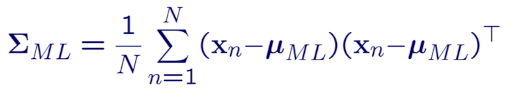

In [4]:
# Option 1: Expand the data and do an outer product of all N vectors, then sum over datapoints.

gaussian_expanded = gaussian[:, :, None]  # shape (100, 2, 1)
mean_expanded = mean[None, :, None]  # shape (1, 2, 1)

diff = gaussian_expanded - mean_expanded  # shape (100, 2, 1)
diff_t = np.transpose(diff, axes=(0, 2, 1))  # shape (100, 1, 2)

prod = diff @ diff_t  # shape (100, 2, 2)
cov = 1/N * np.sum(prod, axis=0)  # shape (2, 2)

print("The estimated covariance using method 1 is:")
print(cov)
print()

# Option 2: Do the sum directly using matrix multiplication.
# shapes: (2, 100) @ (100, 2) = (2, 2)
cov = 1 / N * np.matmul((gaussian - mean).T, (gaussian - mean))
print("The estimated covariance using method 2 is:")
print(cov)
print()

# compare to numpy cov function, slightly different since NP uses the N-1 bias correction
# np.cov expects data of shape (D, N) so we transpose the data
true_cov = np.cov(gaussian.T)        
print("The covariance calculated using Numpy is:")
print(true_cov)

The estimated covariance using method 1 is:
[[1.33765954 2.0820358 ]
 [2.0820358  3.98639368]]

The estimated covariance using method 2 is:
[[1.33765954 2.0820358 ]
 [2.0820358  3.98639368]]

The covariance calculated using Numpy is:
[[1.35117126 2.10306646]
 [2.10306646 4.02666029]]


# Question 2.2: Plotting the graph
Plot the points and indicate the mean via a cross and the covariance via an
ellipse

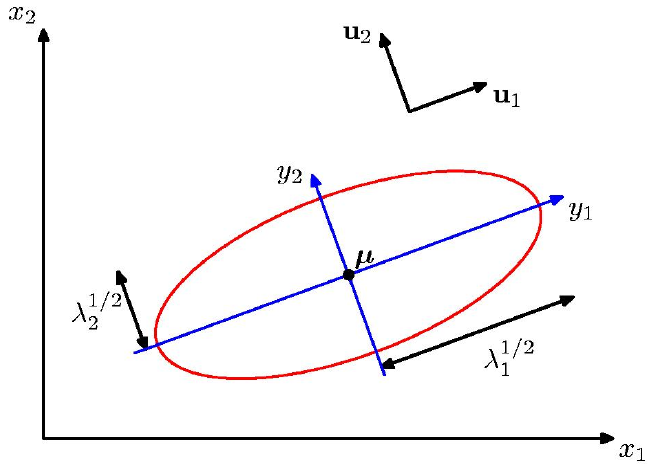

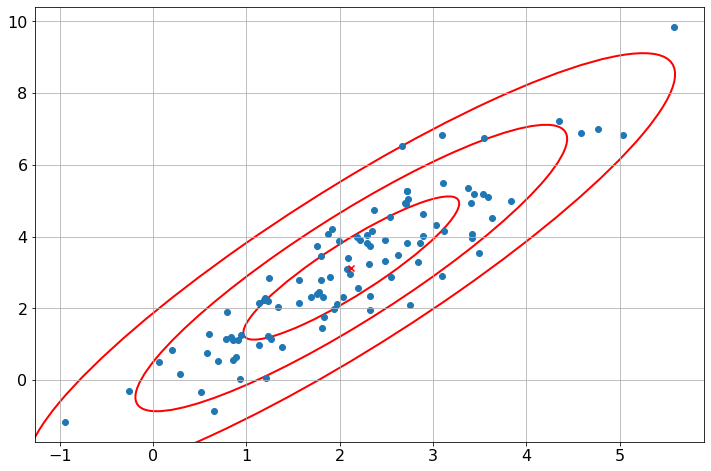

In [5]:
def plot_with_eig(gaussian, mean, cov):
    # calculate the eigen vectors from the covariance matrix
    eig_w, eig_v = np.linalg.eig(cov)    
    fig, ax = plt.subplots(figsize=(12, 8))

    # draws 3 different covariances representing 1, 2 and 3 standard deviations
    # width and height are times by 2 since sqrt of the eigenval only measures half the distance
    for i in range(3):
        ell = Ellipse(xy=[mean[0], mean[1]], 
                      width=np.sqrt(eig_w[0]) * 2 * (i + 1), 
                      height=np.sqrt(eig_w[1]) * 2 * (i + 1), 
                      angle=np.rad2deg(np.arccos(eig_v[0, 0])), 
                      edgecolor='red', lw=2, facecolor='none')
        ax.add_artist(ell)

    plt.scatter(gaussian[:, 0], gaussian[:, 1])
    plt.scatter(mean[0], mean[1], c="red", marker="x")
    plt.grid()
    plt.show()

plot_with_eig(gaussian, mean, cov)

# $\star\star$ Question 3:
Create reduced datasets by considering only the first 2, 5, 10 points and estimate the mean via MAP. 

Use the ML estimate of the covariance $ \Sigma $ <sub>**ML,100**</sub> (estimated from all 100 points) as known covariance. 

Assume the conjugate prior with $\mu_0 = (2,3)^T $ and covariance $\Sigma_0 =\Sigma $ <sub>**ML,100**</sub>


Draw the ML and the MAP estimates into the point clouds (the covariance is the same as it is assumed to be known here). 

How reliable is the ML estimate when there are only few measurements? 

Now work with a slightly wrong prior $\mu_0 = (2,5)^T $
and see how the effect of the prior is reduced as more measurements come
in.

# Question 3.1: Using the correct prior
Using   $\mu_0 = (2,3)^T $

For the formulae for the multivariate Gaussian MAP estimate given mean prior, covariance prior and true covariance see:

[0] [https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf) page 17 equation (211)

[1] [https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf](https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf) Page 17 equation(212)

For details see Christopher M. Bishop, Pattern Recognition and Machine Learning, p. 92.


In [6]:
def estimate_ml_and_map_mean(gaussian, n_reduction, cov, prior_mean):
    gaussian_n = gaussian[0:n_reduction, :]  # create a reduced dataset
    prior_cov = cov  # use cov estimated via ML from the full 100pts as cov prior
    ml_mean_n = np.mean(gaussian_n, axis=0)  # esimate mean using numpy

    cov_n = np.linalg.inv(np.linalg.inv(prior_cov) + n_reduction * np.linalg.inv(cov))  # see [0]
    map_mean_n = cov_n @ ( n_reduction * (np.linalg.inv(cov) @ ml_mean_n) + 
                          (np.linalg.inv(prior_cov) @ prior_mean))  # see [1]

    print(f"The MAP mean estimate from {n_reduction} data points is {map_mean_n}")
    return ml_mean_n, map_mean_n


In [7]:
# get the default color cycle from matplotlib
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
def get_color(i):
    return color_cycle[i % len(color_cycle)]

The MAP mean estimate from 2 data points is [2.79051738 4.17201882]
The MAP mean estimate from 5 data points is [2.21560731 3.29619296]
The MAP mean estimate from 10 data points is [2.56752927 4.00546172]


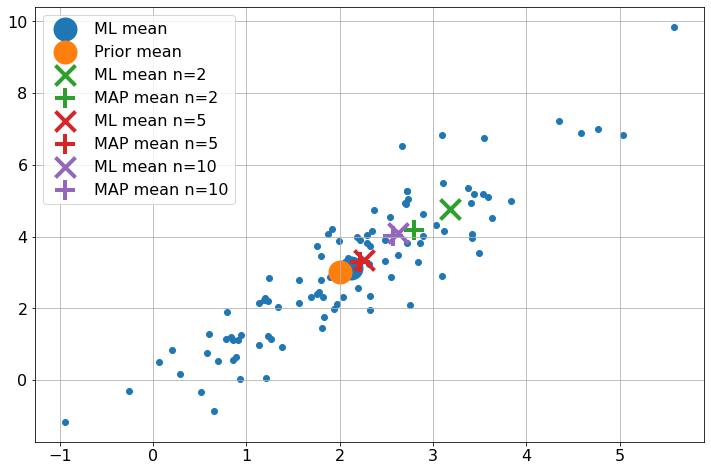

In [8]:

def estimate_and_plot_means(gaussian, ns, prior_mean, ml_mean):
    plt.figure(figsize=(12, 8))
    plt.scatter(gaussian[:, 0], gaussian[:, 1])
    plt.scatter(ml_mean[0], ml_mean[1], label=f"ML mean", c=get_color(0), marker="o", s=400, lw=4)
    plt.scatter(prior_mean[0], prior_mean[1], label=f"Prior mean", c=get_color(1), marker="o", s=400, lw=4)
    for i, n in enumerate(ns):
        ml_mean, map_mean = estimate_ml_and_map_mean(gaussian, n, cov, prior_mean)
        plt.scatter(ml_mean[0], ml_mean[1], label=f"ML mean n={n}", c=get_color(i+2), 
                    marker="x", s=400, lw=4)
        plt.scatter(map_mean[0], map_mean[1], label=f"MAP mean n={n}", c=get_color(i+2), 
                    marker="+", s=400, lw=4)
    plt.legend()
    plt.grid()
    plt.show()
    
prior_mean = np.array([2, 3])
estimate_and_plot_means(gaussian, [2, 5, 10], prior_mean, mean)

# Question 3.2: Using a slightly wrong prior
Using $\mu_0 = (2,5)^T $

The MAP mean estimate from 2 data points is [2.79051738 4.83868548]
The MAP mean estimate from 5 data points is [2.21560731 3.62952629]
The MAP mean estimate from 10 data points is [2.56752927 4.1872799 ]


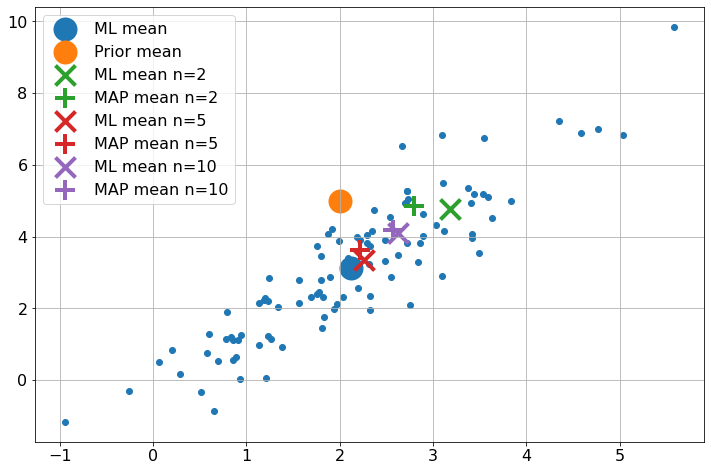

In [9]:
wrong_prior_mean = np.array([2, 5])

estimate_and_plot_means(gaussian, [2, 5, 10], wrong_prior_mean, mean)

# $\star$ Question 4:
Estimate mean and covariance of the dataset *gaussianplus.npz* using ML and show
the result. How well does the estimate reflect the true data?

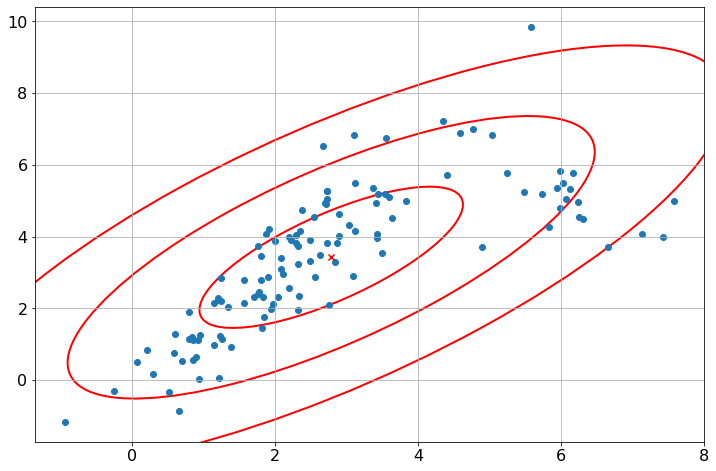

In [10]:
data = np.load('../data/gaussianplus.npz')
gaussianplus = data["arr_0"]

meanplus = np.mean(gaussianplus, axis=0)
covplus = np.cov(gaussianplus.T)   

plot_with_eig(gaussianplus, meanplus, covplus)